In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

import category_encoders as ce


In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample = pd.read_csv('submit_sample.csv', header=None)

In [3]:
train.info(), train.shape, test.shape, sample.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27100 non-null  int64 
 1   job        27100 non-null  object
 2   marital    27100 non-null  object
 3   education  27100 non-null  object
 4   default    27100 non-null  object
 5   balance    27100 non-null  int64 
 6   housing    27100 non-null  object
 7   loan       27100 non-null  object
 8   contact    27100 non-null  object
 9   day        27100 non-null  int64 
 10  month      27100 non-null  object
 11  duration   27100 non-null  int64 
 12  campaign   27100 non-null  int64 
 13  pdays      27100 non-null  int64 
 14  previous   27100 non-null  int64 
 15  poutcome   27100 non-null  object
 16  y          27100 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 3.7+ MB


(None, (27100, 17), (18050, 16), (18050, 2))

In [4]:
test['y'] = -999

In [5]:
all_df = pd.concat([train, test], axis=0)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45150 non-null  int64 
 1   job        45150 non-null  object
 2   marital    45150 non-null  object
 3   education  45150 non-null  object
 4   default    45150 non-null  object
 5   balance    45150 non-null  int64 
 6   housing    45150 non-null  object
 7   loan       45150 non-null  object
 8   contact    45150 non-null  object
 9   day        45150 non-null  int64 
 10  month      45150 non-null  object
 11  duration   45150 non-null  int64 
 12  campaign   45150 non-null  int64 
 13  pdays      45150 non-null  int64 
 14  previous   45150 non-null  int64 
 15  poutcome   45150 non-null  object
 16  y          45150 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 6.2+ MB


In [6]:
all_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,self-employed,married,tertiary,no,98357,yes,no,cellular,6,jul,101,2,417,0,failure,-999
18046,34,blue-collar,married,secondary,no,29621,yes,no,cellular,12,may,345,1,815,0,unknown,-999
18047,34,admin.,single,secondary,no,94260,yes,no,unknown,16,may,121,2,370,0,unknown,-999


In [7]:
all_df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [8]:
# One Hot Encoding
ce_ohe = ce.OneHotEncoder(handle_unknown='impute')
ce_ohe.fit(all_df.drop('y', axis=1))


OneHotEncoder(cols=['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'poutcome'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='impute', return_df=True, use_cat_names=False,
              verbose=0)

In [9]:
X = ce_ohe.transform(all_df[all_df['y'] != -999].drop('y', axis=1))
y = all_df[all_df['y'] != -999]['y']

In [10]:
X.shape, y.shape

((27100, 50), (27100,))

In [11]:
parameters = {
    'max_depth': list(range(3,15, 2)),
    'num_leaves': list(range(21, 41, 5)),
    'min_data_in_leaf': [0, 5, 15, 300],
    'random_state': [0],
    'objective': ['binary'],
}

In [12]:
## lightgbm gridsearch cross validation

lgb = LGBMClassifier()

gcv = GridSearchCV(lgb, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
gcv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13],
                         'min_data_i

In [13]:
gcv.best_params_

{'max_depth': 7,
 'min_data_in_leaf': 15,
 'num_leaves': 21,
 'objective': 'binary',
 'random_state': 0}

In [14]:
## roc_auc
roc_auc_score(y, gcv.predict_proba(X)[:,1])

## No.1. score : 0.9113408811229391

0.916896009705871

([<matplotlib.axis.XTick at 0x1e52eac80c8>,
 <a list of 9 Text xticklabel objects>)

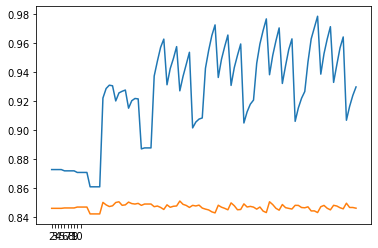

In [15]:
train_score = gcv.cv_results_['mean_train_score']
test_score = gcv.cv_results_['mean_test_score']

plt.plot(train_score)
plt.plot(test_score)
plt.xticks(list(range(0, 10)), list(range(2, 11)))

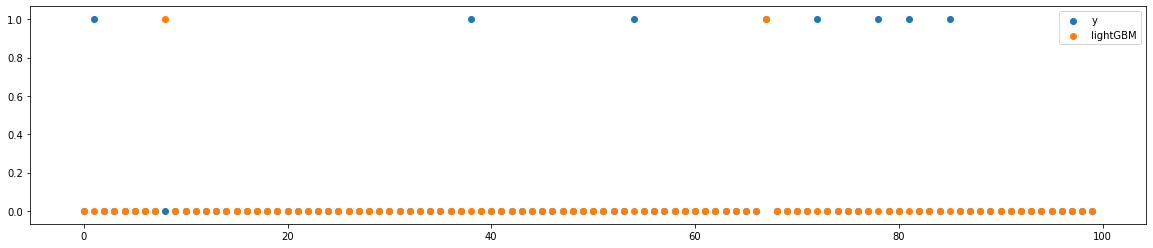

In [16]:
plt.figure(figsize=(20, 4))
plt.scatter(all_df.index[:100], y[:100], alpha=1, label='y')
plt.scatter(all_df.index[:100], gcv.predict(X)[:100], alpha=1, label='lightGBM')
plt.legend()

In [17]:
gcv.predict(X)[200:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [18]:
np.argmax(gcv.predict_proba(X), axis=1)[200:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [23]:
testX = ce_ohe.transform(all_df[all_df['y'] == -999].drop('y', axis=1))
testX

,age,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,...,month_10,month_11,duration,campaign,pdays,previous,poutcome_1,poutcome_2,poutcome_3,poutcome_4
id,,,,,,,,,,,,,,,,,,,,,
0,35,0,0,0,1,0,0,0,0,0,...,0,0,101,2,184,2,0,0,0,1
1,37,1,0,0,0,0,0,0,0,0,...,0,0,158,3,241,0,0,1,0,0
2,31,1,0,0,0,0,0,0,0,0,...,0,0,152,2,47,0,0,1,0,0
3,31,0,0,0,0,0,0,1,0,0,...,0,0,345,2,490,0,0,1,0,0
4,32,1,0,0,0,0,0,0,0,0,...,1,0,126,1,686,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,49,0,0,0,0,0,0,0,0,1,...,0,0,101,2,417,0,0,0,1,0
18046,34,0,0,0,0,0,1,0,0,0,...,0,0,345,1,815,0,0,1,0,0
18047,34,0,0,0,0,0,0,1,0,0,...,0,0,121,2,370,0,0,1,0,0


In [27]:
pred = gcv.predict_proba(testX)
pred = pred[:,1]
pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
sample[1] = pred
sample.to_csv('submit_20200809_01.csv', index=None, header=None)